In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# data analysis and wrangling
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
combine = [train, test]
print('Number of rows (Train): ' + str(len(train)))
print('Number of DUPLICATE rows (Train): ' + str(len(train) - len(train.drop_duplicates())))
print('_' * 40)
print('Number of rows (Test): ' + str(len(test)))
print('Number of DUPLICATE rows (Test): ' + str(len(test) - len(test.drop_duplicates())))
train[:5]

Number of rows (Train): 891
Number of DUPLICATE rows (Train): 0
________________________________________
Number of rows (Test): 418
Number of DUPLICATE rows (Test): 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Check number of unique values for every column
for col in train.columns:
    print(col + ': ' + str(train[col].nunique()) + ' unique values')
print('_'*80)
print(train.info())
print('_'*80)
print(train.describe())
print('_'*80)
print(train.describe(include=['O']))
print('_'*80)
# Check for missing values in every column
print('Number of missing value(s) in every column (Train):')
print(train.isnull().sum())
print('Number of missing value(s) in every column (Test):')
print(test.isnull().sum())

PassengerId: 891 unique values
Survived: 2 unique values
Pclass: 3 unique values
Name: 891 unique values
Sex: 2 unique values
Age: 88 unique values
SibSp: 7 unique values
Parch: 7 unique values
Ticket: 681 unique values
Fare: 248 unique values
Cabin: 147 unique values
Embarked: 3 unique values
________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin     

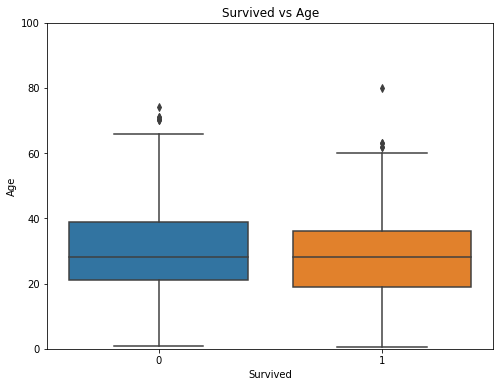

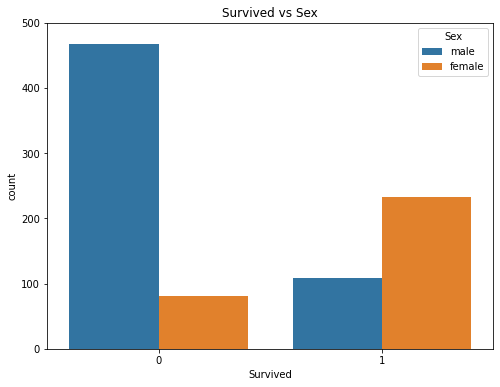

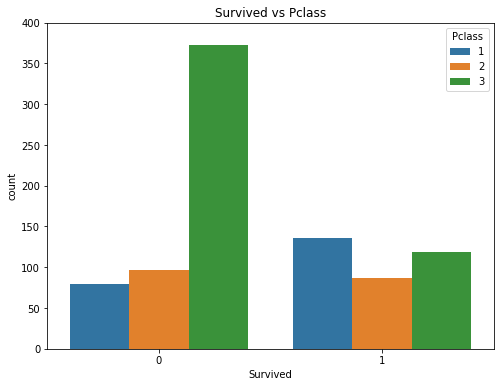

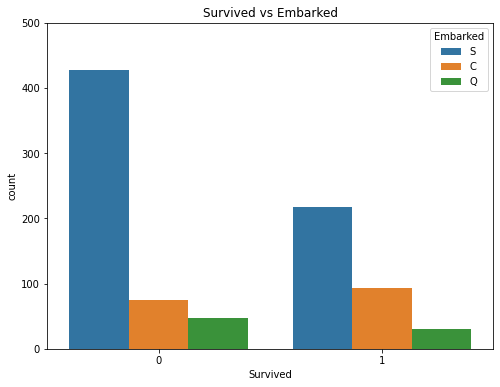

In [5]:
# Plot charts between multiple variables
# age
fig, ax=plt.subplots(1,figsize=(8,6))
sns.boxplot(x='Survived',y='Age', data=train)
ax.set_ylim(0,100)
plt.title("Survived vs Age")
plt.show()

# Sex
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Sex', data=train)
ax.set_ylim(0,500)
plt.title("Survived vs Sex")
plt.show()

# Pclass
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Pclass', data=train)
ax.set_ylim(0,400)
plt.title("Survived vs Pclass")
plt.show()

# Embarked
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Embarked', data=train)
ax.set_ylim(0,500)
plt.title("Survived vs Embarked")
plt.show()

In [6]:
# Drop PassengerId, Ticket and Cabin columns
train = train.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1)
test = test.drop(['Ticket', 'Cabin'], axis = 1)
combine = [train, test]

In [7]:
## feature Engineering

In [8]:
# Crate FamilySize column from SibSp and Parch
for df in combine:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [9]:
# Create Title column from Name
for df in combine:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [10]:
# Replace titles to more common names and group rare titles
common = ['Master', 'Mr', 'Miss', 'Mrs']
for df in combine:
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = [x if x in common else 'Rare' for x in df['Title']]

train['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

In [11]:
# Encode columns
for df in combine:
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})
    #df['Title'] = df['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4})
    
title_ohe1 = pd.get_dummies(train['Title'], prefix = 'Title', drop_first = True)
train = pd.concat([train.drop('Title', axis = 1), title_ohe1], axis = 1)

title_ohe2 = pd.get_dummies(test['Title'], prefix = 'Title', drop_first = True)
test = pd.concat([test.drop('Title', axis = 1), title_ohe2], axis = 1)

In [12]:
# Drop Name, SibSp and Parch columns
train = train.drop(['Name', 'SibSp', 'Parch'], axis = 1)
test = test.drop(['Name', 'SibSp', 'Parch'], axis = 1)
combine = [train, test]

In [13]:
# Check correlation of Age with other variables
age_corr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
age_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
age_corr[age_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
7,Age,Age,1.000000
26,Age,Pclass,0.369226
37,Age,FamilySize,0.301914
38,Age,Title_Miss,0.277827
47,Age,Title_Mr,0.206341
50,Age,Title_Rare,0.194639
60,Age,Title_Mrs,0.178069
77,Age,Fare,0.096067
78,Age,Sex,0.093254
82,Age,Survived,0.077221


In [14]:
# Impute Age based on Pclass
impute_ages = np.zeros((2,3))
for df in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            impute_df = df[(df['Sex'] == i) & \
                                  (df['Pclass'] == j+1)]['Age'].dropna()
            impute_ages[i,j] = int(impute_df.median())
            
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1), 'Age'] = impute_ages[i,j]

Check correlation between Embarked & Pclass



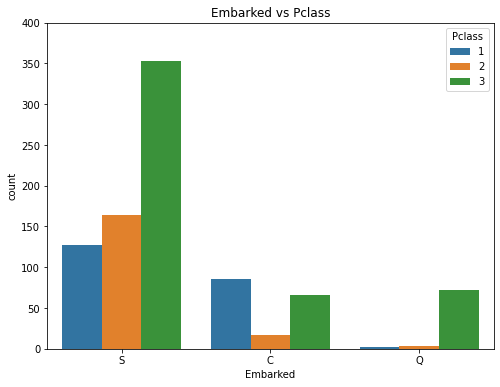

In [15]:
# Check correlation between Embarked & Pclass
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Embarked',hue='Pclass', data=train)
ax.set_ylim(0,400)
plt.title("Embarked vs Pclass")
print('Check correlation between Embarked & Pclass\n')
plt.show()

In [16]:
impute_embarked= ['', '', '']
for df in combine:
    for i in range(0, 3):
        impute_val = df[df['Pclass'] == i+1]['Embarked'].dropna().mode()[0]
        impute_embarked[i] = impute_val
        
    for i in range(0, 3):
        df.loc[ (df.Embarked.isnull()) & (df.Pclass == i+1), 'Embarked'] = impute_embarked[i]

In [17]:
# for df in combine:
#     df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

embarked_ohe1 = pd.get_dummies(train['Embarked'], prefix = 'Embarked', drop_first = True)
train = pd.concat([train.drop('Embarked', axis = 1), embarked_ohe1], axis = 1)

embarked_ohe2 = pd.get_dummies(test['Embarked'], prefix = 'Embarked', drop_first = True)
test = pd.concat([test.drop('Embarked', axis = 1), embarked_ohe2], axis = 1)

combine = [train, test]

In [18]:
imputer = SimpleImputer()
test['Fare'] = list(imputer.fit_transform(test[['Fare']]))
test['Fare'] = [x[0] for x in test['Fare']]

# Check if there's any missing values left
print('Number of missing value(s) in every column (Train):')
print(train.isnull().sum())
print('Number of missing value(s) in every column (Test):')
print(test.isnull().sum())

Number of missing value(s) in every column (Train):
Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
FamilySize    0
Title_Miss    0
Title_Mr      0
Title_Mrs     0
Title_Rare    0
Embarked_Q    0
Embarked_S    0
dtype: int64
Number of missing value(s) in every column (Test):
PassengerId    0
Pclass         0
Sex            0
Age            0
Fare           0
FamilySize     0
Title_Miss     0
Title_Mr       0
Title_Mrs      0
Title_Rare     0
Embarked_Q     0
Embarked_S     0
dtype: int64


**Modelling**

In [19]:
# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [20]:
X = train.drop(columns = 'Survived')
X = pd.get_dummies(X, drop_first = True)

y = train['Survived']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
def find_best_model(X_train, X_test, y_train, y_test):
    # Logistic Regression
    logreg = LogisticRegression(max_iter = 600, random_state = 42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    logreg_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(random_state = 42)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    decision_tree_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Random Forest
    random_forest = RandomForestClassifier(random_state = 42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    random_forest_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # XGBoost
    xgb = XGBClassifier(random_state = 42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    xgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # GBM
    gbm = GradientBoostingClassifier(random_state = 42)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    gbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # LightGBM
    lgbm = LGBMClassifier(random_state = 42)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    lgbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        
    # Catboost
    catb = CatBoostClassifier(verbose = 0, random_state = 42)
    catb.fit(X_train, y_train)
    y_pred = catb.predict(X_test)
    catb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Histogram-based Gradient Boosting Classification Tree
    hgb = HistGradientBoostingClassifier(random_state = 42)
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)
    hgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    model_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'GBM', 'LightGBM', 'Catboost', 'HistBoost'],
                       'Score': [logreg_acc, decision_tree_acc, random_forest_acc, xgb_acc, gbm_acc, lgbm_acc, catb_acc, hgb_acc]})
    print(model_df.sort_values('Score', ascending = False).reset_index(drop = True))

In [23]:
find_best_model(X_train, X_test, y_train, y_test)

                 Model  Score
0        Random Forest  84.92
1             LightGBM  84.36
2            HistBoost  84.36
3              XGBoost  83.80
4                  GBM  83.24
5             Catboost  83.24
6  Logistic Regression  79.89
7        Decision Tree  77.65


***Random Forest***

In [24]:
rfc = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 200, 300], # The number of boosting stages to perform
    'max_features': ['auto'], # The number of features to consider when looking for the best split
    'max_depth' : [4, 6, 8], # The maximum depth of the individual regression estimators.
    'criterion' :['gini', 'entropy'] #Function to measure the quality of a split
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print('Best hyperparameters:',CV_rfc.best_params_)

X_test = test.drop('PassengerId', axis = 1)
predictions = CV_rfc.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId,
                      'Survived': predictions})

output.to_csv('titanic-submission.csv', index= False)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 300}
